In [1]:
import pandas as pd
from datetime import datetime
from zoe import cases, query, pickle, find_previous, plot_study, plot_study_evolution

In [2]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index, format='%Y%m%d')
uk_active_cases

,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,67513,None,None,86085.715275
2020-06-13,67514,None,None,79940.811469
2020-06-14,67515,None,None,74244.112992
2020-06-15,67516,None,None,68878.187593
2020-06-16,67517,None,None,64137.552455
...,...,...,...,...
2021-06-09,67875,None,None,124289.508203
2021-06-10,67876,None,None,134174.226190
2021-06-11,67877,None,None,143893.206997


In [3]:
curr_date = uk_active_cases.index.max()
print(pickle(uk_active_cases, 'uk_active_cases', curr_date))

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-06-13_2021-06-13-19-21.pickle


In [4]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-06-12_2021-06-12-20-20.pickle


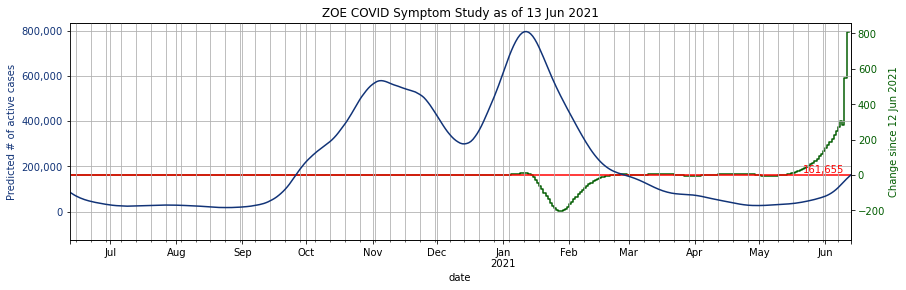

In [5]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

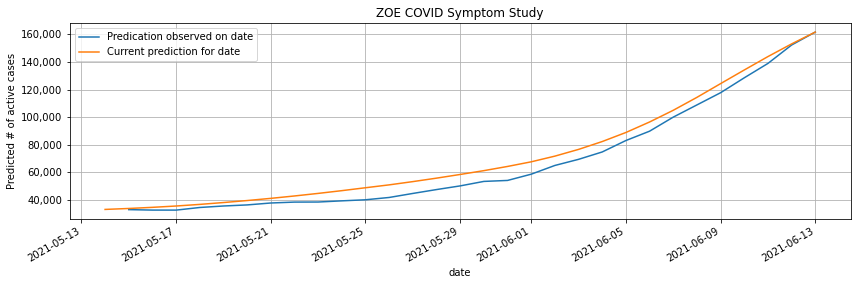

In [6]:
plot_study_evolution(curr_date, days=30)

In [7]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)

In [8]:
for_date, = prevalence_map['data_status'].unique()
print(pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y')))

/Users/chris/coronavirus/data/zoe_prevalence_map_2021-06-13_2021-06-13-19-21.pickle


In [9]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
266,Bolton,E08000001,2.362287
269,Rochdale,E08000005,2.110558
373,North Ayrshire,S12000021,1.842865
308,Perth and Kinross,S12000024,1.716881
270,Salford,E08000006,1.668084
71,South Derbyshire,E07000039,1.597783
317,Renfrewshire,S12000038,1.512640
171,Preston,E07000123,1.326883
311,South Ayrshire,S12000028,1.260772
164,Chorley,E07000118,1.224321
